In [1]:
import re
import urllib
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from IPython import display
import matplotlib.pyplot as plt

C:\Users\s381731\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# torch.manual_seed(113145)

# Single RNN cell test

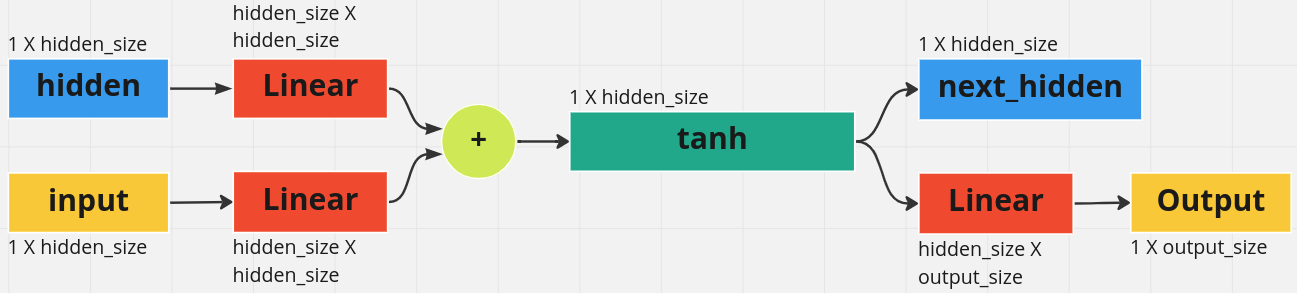

In [3]:
display.Image('imgs/rnn_cell.png')

Generate some fake samples

In [4]:
# Hyper Parameters
n_samples = 10 # generation 10 samples

# Create some fake data
# Each sample in the batch has 50 dimensions, as a 50-dim embedding
batch = torch.randn(n_samples, 50) 
# The output is a 10-dim space
target = torch.zeros(n_samples, 10)

In [5]:
print(batch.shape)

torch.Size([10, 50])


Run step by step

In [6]:
embed_layer = nn.Linear(50, 64) # embedding size is 50, hidden size is 64
emb = embed_layer(batch)

linear_layer = nn.Linear(64, 64) 
i2h = linear_layer(emb) # Linear transformation of the embedded vector

hidden = torch.zeros(emb.shape) 
h2h = linear_layer(hidden)   # Linear transformation of the hidden vector

combined = i2h + h2h    # Combine i2h and h2h by adding two together 

out = torch.tanh(combined) # Nonlinear activation

out_layer = nn.Linear(64, 10) # hidden size is 64, output size is 10
hidden = out
output = out_layer(out)

In [7]:
# print(emb.shape)
# print(i2h.shape)
# print(h2h.shape)
# print(combined.shape)
print(output)

tensor([[-1.8417e-01, -3.6585e-01,  9.7594e-02,  3.0113e-04, -1.7401e-01,
         -6.0177e-02,  8.6637e-02, -2.3155e-01, -7.8317e-02, -5.8632e-02],
        [-9.8612e-03, -3.1520e-01,  9.1807e-02,  1.0368e-01, -2.6956e-01,
          3.9124e-02, -1.2529e-01, -2.9518e-01,  7.5055e-02,  1.2544e-01],
        [ 2.1664e-01, -6.3822e-01,  9.9980e-02, -7.1095e-02, -6.2970e-02,
         -5.7725e-02,  9.1720e-02, -3.5364e-01,  1.1052e-01,  4.5492e-02],
        [ 6.8037e-02,  3.2874e-01, -3.3130e-01, -4.9432e-02, -2.2244e-01,
          1.0626e-01, -7.9228e-02, -8.4964e-02,  3.3136e-01, -2.2594e-01],
        [-1.8348e-01, -1.6341e-01, -7.9955e-02, -2.8147e-02, -2.3613e-01,
         -1.6423e-01,  2.8876e-02,  9.7065e-02, -2.1907e-01,  5.7349e-02],
        [-1.1058e-01, -4.9176e-01,  6.7694e-02, -1.1186e-01,  2.1758e-01,
         -2.6772e-01,  3.7867e-01, -2.1002e-01, -1.4763e-01,  2.0397e-01],
        [ 1.6115e-01, -1.6861e-01,  7.0360e-03,  3.7027e-01,  1.2386e-01,
         -3.5397e-01, -2.8621e-0

# Stack the cell to build the RNN model

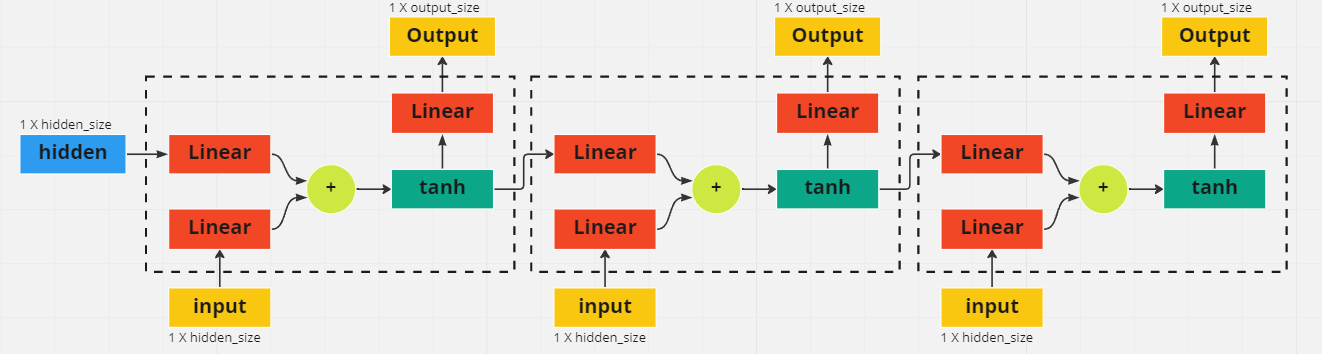

In [8]:
display.Image('imgs/simple_rnn.png')

Rewrite above rnn cell as a class

In [9]:
class SimpleRNN(nn.Module):

    # you can also accept arguments in your model constructor
    def __init__(self, embed_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()

        self.embed_size = embed_size
        self.hidden_size = hidden_size

        self.embed = nn.Linear(embed_size, hidden_size)
        self.hidden = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
    
    def init_hidden(self, input):
        return torch.zeros(self.embed(input).shape)

    def forward(self, input, hidden):
        # convert the embed into 1 X hidden (1, hidden_size)
        emb = self.embed(input)

        # Linear transformation for both embedded input and hidden
        i2h = self.hidden(emb)
        h2h = self.hidden(hidden)

        # Combine using matrix adding
        combined = i2h + h2h

        # Activated using tanh function to get the next hidden
        # Use output linear transforamtion to get the desired output shape
        next_hidden = torch.tanh(combined)
        output = self.output(next_hidden)
        
        return next_hidden, output

In [10]:
# Create the rnn model
simple_rnn = SimpleRNN(embed_size=50, hidden_size=64, output_size=10) 

In [11]:
hidden = simple_rnn.init_hidden(batch) # initalize the hidden 

In [12]:
hidden, output = simple_rnn(batch, hidden) # get the output vector

In [13]:
print(output.shape)
print(output)

torch.Size([10, 10])
tensor([[-1.9474e-01,  4.4482e-02,  1.8929e-01, -1.4970e-01, -1.2199e-01,
          2.0468e-01,  1.2329e-01,  1.9461e-01, -1.1518e-01, -4.1090e-02],
        [-3.8605e-01, -5.1431e-02,  9.5742e-02, -2.4924e-01, -1.6251e-01,
         -9.4962e-02,  3.2785e-01,  3.7027e-01, -1.8302e-01,  2.3637e-02],
        [-1.2109e-01,  9.2790e-02,  1.0667e-01, -7.5990e-02,  2.3358e-01,
          9.3059e-02,  2.2099e-01,  2.8593e-01, -8.3277e-02,  1.2816e-01],
        [-2.0320e-01,  5.1442e-02, -9.8964e-02, -1.5557e-01, -1.1304e-01,
          8.6710e-02, -4.9656e-02,  3.6005e-01, -1.8694e-01, -1.6142e-01],
        [-2.5714e-01,  8.7283e-02,  2.0154e-01, -1.4937e-01, -3.5658e-01,
         -1.7920e-01,  2.5122e-03, -1.7317e-01, -7.7608e-02,  1.0884e-01],
        [-3.0468e-01, -1.5329e-01,  2.5955e-01, -6.7539e-02,  9.8750e-02,
         -1.1968e-03, -8.6618e-02,  6.5401e-02,  2.2201e-02,  2.4291e-01],
        [ 5.1864e-02, -1.5340e-01,  1.8679e-01, -2.2879e-01, -2.1249e-01,
          1

Train on the 10 sample dataset once

In [14]:
loss_fn = nn.MSELoss() # Define loss function

In [15]:
def train_step(batch, loss_fn, lr):
    hidden = simple_rnn.init_hidden(batch) # initialize the hidden 
    loss = 0 # initialize the loss
    
    # model gradient initalization
    simple_rnn.zero_grad()

    # Forward
    hidden, output = simple_rnn(batch, hidden)

    # Loss 
    loss = loss_fn(output, target)

    # backward
    loss.backward()

    # Update
    for p in simple_rnn.parameters():
        p.data.add_(p.grad.data, alpha=-lr)
    
    return loss.item()

In [16]:
train_step(batch, loss_fn, lr=0.01)

0.03333855792880058

Train on all 10 samples with EPOCH times

In [17]:
EPOCH = 1000

for i in range(EPOCH):
    loss = train_step(batch, loss_fn, 0.005)

    if i % 50 == 0:
        print(f'{i}/{EPOCH}: Loss={loss}')

0/1000: Loss=0.03287237510085106
50/1000: Loss=0.023623133078217506
100/1000: Loss=0.01760421320796013
150/1000: Loss=0.013541982509195805
200/1000: Loss=0.010708753019571304
250/1000: Loss=0.008670938201248646
300/1000: Loss=0.007162163965404034
350/1000: Loss=0.006014676298946142
400/1000: Loss=0.005120447371155024
450/1000: Loss=0.004408374894410372
500/1000: Loss=0.0038306203205138445
550/1000: Loss=0.0033542632590979338
600/1000: Loss=0.0029561296105384827
650/1000: Loss=0.00261952867731452
700/1000: Loss=0.0023321756161749363
750/1000: Loss=0.0020848363637924194
800/1000: Loss=0.00187043403275311
850/1000: Loss=0.0016834498383104801
900/1000: Loss=0.0015195129672065377
950/1000: Loss=0.0013751109363511205


View the prediction

In [18]:
hidden = simple_rnn.init_hidden(batch)
_, preds = simple_rnn(batch, hidden)
print(preds)

tensor([[ 0.0174,  0.0436,  0.0201,  0.0244,  0.0331,  0.0312,  0.0104, -0.0357,
          0.0238, -0.0564],
        [-0.0530, -0.0255, -0.0115, -0.0236, -0.0050, -0.0489,  0.0708,  0.0560,
         -0.0126,  0.0199],
        [ 0.0140,  0.0532, -0.0108,  0.0305,  0.0792,  0.0157,  0.0474, -0.0091,
         -0.0022, -0.0044],
        [-0.0097,  0.0097, -0.0315, -0.0523,  0.0201,  0.0012, -0.0169, -0.0377,
         -0.0363, -0.0059],
        [ 0.0080,  0.0164,  0.0288, -0.0243, -0.0252, -0.0206, -0.0113, -0.0798,
          0.0062,  0.0009],
        [-0.0586, -0.0642,  0.0350, -0.0107,  0.0504,  0.0159, -0.0059, -0.0176,
         -0.0039,  0.0347],
        [ 0.0604, -0.0482,  0.0189, -0.0626, -0.0605,  0.0202, -0.0533, -0.0309,
         -0.0019,  0.0406],
        [-0.0366, -0.0103, -0.0381,  0.0295, -0.0482, -0.0183, -0.0180,  0.0206,
         -0.0377, -0.0055],
        [ 0.0308,  0.0189,  0.0107,  0.0225, -0.0461, -0.0394, -0.0549,  0.0465,
          0.0280, -0.0228],
        [ 0.0142, -

In [19]:
print(target)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


# Train on a real dataset

In [20]:
# Use the URL to obtain the corpus from the web 
url = 'https://cogcomp.seas.upenn.edu/Data/QA/QC/train_1000.label'

try:
    url_response = urllib.request.urlopen(url) 
except urllib.error.HTTPError as e:
    e.msg += ' ' + url
    raise

# Obtain raw text from the given URL
# Decode the bytes using UTF-8 format
# Use the keyword 'ignore' for decoding
raw_text = url_response.read().decode('utf8', 'ignore')

print(type(raw_text))
raw_text[:100]

<class 'str'>


'DESC:manner How did serfdom develop in and then leave Russia ?\nENTY:cremat What films featured the c'

## Data Preprocessing

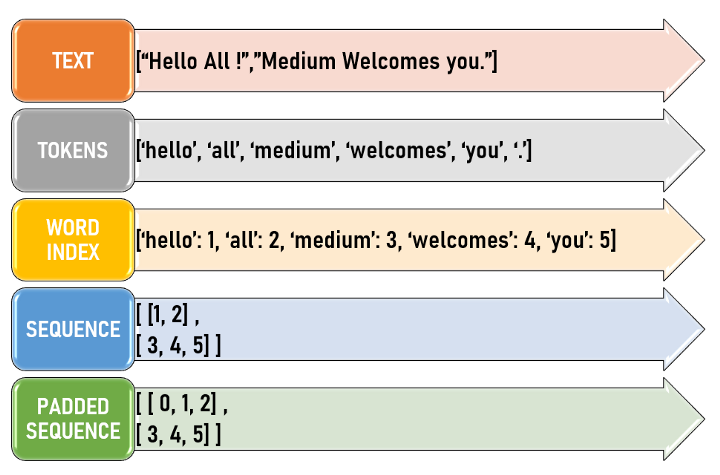

In [21]:
display.Image('imgs/text_pre_processing.png')

In [22]:
# Remove the whitespace in the beginning and the end
# Split the string and convert it into a list of questions
ques_list = raw_text.strip().split('\n')

# Show the last five samples
for q in ques_list[-5:]: 
    print(q) 

print(f'Total tagged questions: {len(ques_list)}')

DESC:manner How do you look up criminal records on the Internet ?
LOC:other Where is the actress , Marion Davies , buried ?
DESC:desc What is an example of an actual case of using the Fourteenth Amendment ?
HUM:ind Who was the Charlie perfume woman ?
HUM:ind Who portrayed `` Rosanne Rosanna-Dana '' on the television show `` Saturday Night Live '' ?
Total tagged questions: 1000


Use one sample in the question list to show the data processing


In [23]:
rand_idx = random.randint(0, len(ques_list))
sample = ques_list[rand_idx]
print(sample)

split_sample = sample.split(':')
print(split_sample)

mark, ques = split_sample[0], split_sample[1][:-1] # Remove the question mark
print([ques, mark])

DESC:manner How do fuel injectors work ?
['DESC', 'manner How do fuel injectors work ?']
['manner How do fuel injectors work ', 'DESC']


Data processing on the whole dataset

In [24]:
tagged_ques_list = [[q.split(':')[1][:-1], q.split(':')[0]] for q in ques_list]

In [25]:
ques, tags = list(zip(*tagged_ques_list)) # Split the questions and the tags
ques, tags = list(ques), list(tags) # Convert from tuple to list

print(ques[10:15])
print(tags[10:15])

['date When was Ozzy Osbourne born ', 'reason Why do heavier objects travel downhill faster ', 'ind Who was The Pride of the Yankees ', 'ind Who killed Gandhi ', 'event What is considered the costliest disaster the insurance industry has ever faced ']
['NUM', 'DESC', 'HUM', 'HUM', 'ENTY']


Number masking for search space reduction

In [26]:
for i, q in enumerate(ques):
    ques[i] = re.sub('\d', '#', q).split()

Extract all words from the all questions

In [27]:
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(ques)))

print(f'Total words: {len(vocab)}')
print(vocab[:10])

tags_set = list(set(tags))
print(f'Total tags: {len(tags_set)}')
print(tags_set)

Total words: 2849
['Winston', 'sentence', 'White', 'very', 'cat-bear', 'bogs', 'League', 'Jogis', 'tennis', 'intercourse']
Total tags: 6
['NUM', 'ABBR', 'HUM', 'ENTY', 'DESC', 'LOC']


Build the word2index and tag2index dictionary

In [28]:
word2index = {'<P>':0, '<U>':1}
init_len = len(word2index)
word2index.update({w:(i + init_len) for i, w in enumerate(vocab)})
index2word = {i:w for w, i in word2index.items()}

# Use single number for encoding
# tag2index = {t:i for i, t in enumerate(set(tags))}
# index2tag = {i:t for t, i in tag2index.items()}

# Use one-hot encoding
tag_onehot = F.one_hot(torch.arange(0, len(tags_set)), num_classes=len(set(tags)))
tag2index = {tags_set[i]:tag_onehot[i] for i in range(len(tags_set))}

index2tag = {i:t for t, i in tag2index.items()}

print(tag2index)
print(index2tag)

{'NUM': tensor([1, 0, 0, 0, 0, 0]), 'ABBR': tensor([0, 1, 0, 0, 0, 0]), 'HUM': tensor([0, 0, 1, 0, 0, 0]), 'ENTY': tensor([0, 0, 0, 1, 0, 0]), 'DESC': tensor([0, 0, 0, 0, 1, 0]), 'LOC': tensor([0, 0, 0, 0, 0, 1])}
{tensor([1, 0, 0, 0, 0, 0]): 'NUM', tensor([0, 1, 0, 0, 0, 0]): 'ABBR', tensor([0, 0, 1, 0, 0, 0]): 'HUM', tensor([0, 0, 0, 1, 0, 0]): 'ENTY', tensor([0, 0, 0, 0, 1, 0]): 'DESC', tensor([0, 0, 0, 0, 0, 1]): 'LOC'}


In [29]:
# tag2index[tags[rand_idx]].cuda()

# Prepare dataset

set the device for computation

In [30]:
USE_CUDA = torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [31]:
def to_seq_tensor(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index["<U>"], seq))
    return Variable(LongTensor(idxs))

def to_tag_tensor(tag, tag2index):
    # return Variable(LongTensor([tag2index[tag]]))
    return tag2index[tag].cuda()

ques_tensor, tags_tensor = [], []
for pair in zip(ques, tags):
    ques_tensor.append(to_seq_tensor(pair[0], word2index).view(1, -1))
    tags_tensor.append(to_tag_tensor(pair[1], tag2index).view(1, -1))

ques_tags_tensor = list(zip(ques_tensor, tags_tensor))

Split the dataset

In [32]:
def spilt_data(dataset, training_ratio=0.9):
    random.shuffle(dataset)
    split_index = int(len(dataset) * training_ratio)
    return dataset[:split_index], dataset[split_index:]

train_data, test_data = spilt_data(ques_tags_tensor)

print(len(train_data))
print(train_data[5])
print(len(test_data))
print(test_data[5])

900
(tensor([[2275,  779, 2340,  540, 2275, 1876,  540, 1347, 1474]],
       device='cuda:0'), tensor([[1, 0, 0, 0, 0, 0]], device='cuda:0'))
100
(tensor([[ 311,  779,  759, 1174,  956, 2364, 1857, 1520, 2755,  607]],
       device='cuda:0'), tensor([[0, 0, 1, 0, 0, 0]], device='cuda:0'))


# Encode the sentence

In [33]:
q_t, t_t = zip(*train_data[:100]) # Formalize the first 100 samples for demo
print(q_t[0])

tensor([[ 153,  779, 2340, 2353, 2755, 2402]], device='cuda:0')


Encode the first sentence in the batch step by step

In [34]:
first_sent = q_t[5].float().view(-1)
first_sent

tensor([2275.,  779., 2340.,  540., 2275., 1876.,  540., 1347., 1474.],
       device='cuda:0')

In [35]:
HIDDEN_SIZE = 64
embed_layer = nn.Linear(1, HIDDEN_SIZE, device='cuda') 
linear_layer = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE, device='cuda') 
dense_layer = nn.Linear(HIDDEN_SIZE, len(tags_set), device='cuda') 
# softmax = nn. Softmax(dim=1)

In [36]:
hidden = torch.zeros(1, HIDDEN_SIZE, device='cuda') 

for i in range(len(first_sent)):
    e_w = first_sent[i].view(1, -1).float()
    # embed each word in the sentence
    emb = embed_layer(e_w) 
    i2h = linear_layer(emb) # Linear transformation of the embedded vector
    h2h = linear_layer(hidden)   # Linear transformation of the hidden vector
    combined = i2h + h2h    # Combine i2h and h2h by adding two together 
    output = torch.tanh(combined) # Nonlinear activation
    hidden = output
    output = dense_layer(output)
    # output = softmax(output)

In [37]:
# print(output.shape)
print(output, t_t[0])

tensor([[-0.6691, -0.2519, -0.0355, -0.2386,  0.3739,  0.6050]],
       device='cuda:0', grad_fn=<AddmmBackward0>) tensor([[0, 0, 0, 0, 0, 1]], device='cuda:0')


Encode one sentence in the batch using the RNNEncoder

In [38]:
class RNNEncoder(nn.Module):

    # you can also accept arguments in your model constructor
    def __init__(self, embed_size, hidden_size, output_size):
        super(RNNEncoder, self).__init__()

        self.embed_size = embed_size
        self.hidden_size = hidden_size

        self.embed = nn.Linear(embed_size, hidden_size, device='cuda')
        self.hidden = nn.Linear(hidden_size, hidden_size, device='cuda')
        self.output = nn.Linear(hidden_size, output_size, device='cuda')
        self.relu = nn.ReLU()
        # self.softmax = nn.Softmax(dim=1)
        # self.dense = nn.Linear(output_size, 1, device='cuda')
    
    def init_hidden(self, input):
        return torch.zeros(self.embed(input).shape, device='cuda')

    def forward(self, input, hidden):
        # convert the embed into 1 X hidden (1, hidden_size)
        emb = self.embed(input)

        # Linear transformation for both embedded input and hidden
        i2h = self.hidden(emb)
        h2h = self.hidden(hidden)

        # Combine using matrix adding
        combined = i2h + h2h

        # Activated using tanh function to get the next hidden
        # Use output linear transforamtion to get the desired output shape
        # next_hidden = torch.tanh(combined)
        next_hidden = self.relu(combined)
        output = self.output(next_hidden)
        # output = self.softmax(output)
        # output = self.dense(output)
        
        return next_hidden, output

In [39]:
HIDDEN_SIZE = 64

model = RNNEncoder(embed_size=1, hidden_size=HIDDEN_SIZE, output_size=len(tags_set))

if USE_CUDA:
    model = model.cuda()

In [40]:
sent = F.normalize(q_t[2].float()).view(-1)
print(sent)
hidden = torch.zeros(1, HIDDEN_SIZE, device='cuda') 

for i in range(len(sent)):
    e_w = sent[i].view(1, -1).float()
    hidden, output = model(e_w, hidden)

print(output)

tensor([0.0375, 0.1910, 0.3984, 0.2106, 0.6056, 0.6262], device='cuda:0')
tensor([[0.0606, 0.3104, 0.0439, 0.2220, 0.1292, 0.2077]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


Encode the whole batch using the model

In [41]:
outputs = torch.zeros(len(q_t), len(tags_set), device='cuda')
for q_i in range(len(q_t)):
    # sent = q_t[q_i].view(-1)
    sent = F.normalize(q_t[q_i].float()).view(-1)
    # print(sent)
    hidden = torch.zeros(1, HIDDEN_SIZE, device='cuda') 

    for i in range(len(sent)):
        e_w = sent[i].view(1, -1).float()
        hidden, output = model(e_w, hidden)
    # print(output)
    outputs[q_i] = output

In [42]:
outputs

tensor([[ 3.2242e-02,  3.2616e-01,  4.3339e-02,  2.1723e-01,  1.2677e-01,
          2.1378e-01],
        [ 9.1191e-04,  3.1665e-01,  7.4601e-02,  2.1196e-01,  1.3477e-01,
          2.0235e-01],
        [ 6.0628e-02,  3.1038e-01,  4.3908e-02,  2.2199e-01,  1.2923e-01,
          2.0771e-01],
        [-9.3140e-03,  3.2135e-01,  7.6511e-02,  2.2462e-01,  1.2335e-01,
          2.0242e-01],
        [ 4.7726e-02,  3.2043e-01,  5.1219e-02,  2.2576e-01,  1.1391e-01,
          2.3439e-01],
        [ 2.2512e-02,  3.1547e-01,  5.3592e-02,  2.0559e-01,  1.4573e-01,
          2.0562e-01],
        [ 1.9844e-02,  3.2221e-01,  4.9434e-02,  2.1102e-01,  1.2799e-01,
          2.0832e-01],
        [-9.7425e-03,  3.2068e-01,  7.5761e-02,  2.2895e-01,  1.3735e-01,
          1.9238e-01],
        [ 1.4437e-02,  3.1440e-01,  6.7594e-02,  2.0526e-01,  1.5268e-01,
          1.9860e-01],
        [ 1.5660e-02,  3.2496e-01,  5.1317e-02,  2.1500e-01,  1.2534e-01,
          2.0918e-01],
        [ 9.4738e-03,  3.1927e

Compute the loss on the batch

In [43]:
loss_function = nn.MSELoss()
loss = loss_function(outputs, torch.cat(t_t).float())
loss.backward()

Train the model on the whole training dataset

In [44]:
def get_batch(batch_size, train_data):
    """ Get a batch from the train dataset """
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [45]:
# Hyper parameters
EPOCH = 5
BATCH_SIZE = 100
LR = 0.001

In [46]:
model = RNNEncoder(embed_size=1, hidden_size=HIDDEN_SIZE, output_size=len(tags_set))
if USE_CUDA:
    model = model.cuda()
    
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [47]:
losses, steps = [], []
count = 0

for e in range(EPOCH):
    print(f'{e+1}/{EPOCH}======================')

    for batch_i, batch in enumerate(get_batch(BATCH_SIZE, train_data)):
        q_t, t_t = zip(*batch) # Obtain the questions and tags in each batch

        # Initialize the batch prediction outputs and loss
        outputs = torch.zeros(len(q_t), len(tags_set), device='cuda')
        loss = 0

        # Encode each sentence
        for q_i in range(len(q_t)):
            # sent = q_t[q_i].view(-1)
            sent = F.normalize(q_t[q_i].float()).view(-1)
            hidden = torch.zeros(1, HIDDEN_SIZE, device='cuda') 

            # Use the RNN model to scan the sentence
            # Each word is embeded by a single integer
            for w_i in range(len(sent)):
                e_w = sent[w_i].view(1, -1).float()
                hidden, output = model(e_w, hidden)
            outputs[q_i] = output
        
        loss = loss_function(outputs, torch.cat(t_t).float())
        losses.append(loss.item())
        count += 1
        steps.append(count)
        print(f'{batch_i+1}/{len(train_data) // BATCH_SIZE}: Loss={loss.item()}')

        loss.backward()

        optimizer.step()

1/5======================
1/9: Loss=0.1442732810974121
2/9: Loss=0.14131365716457367
3/9: Loss=0.13907407224178314
4/9: Loss=0.1411459594964981
5/9: Loss=0.14274050295352936
6/9: Loss=0.14511102437973022
7/9: Loss=0.14615420997142792
8/9: Loss=0.14521414041519165
9/9: Loss=0.14479678869247437
2/5======================
1/9: Loss=0.1438901275396347
2/9: Loss=0.14846166968345642
3/9: Loss=0.1402721405029297
4/9: Loss=0.14961375296115875
5/9: Loss=0.15446318686008453
6/9: Loss=0.1558082103729248
7/9: Loss=0.1657637506723404
8/9: Loss=0.16745229065418243
9/9: Loss=0.16688525676727295
3/5======================
1/9: Loss=0.1652214527130127
2/9: Loss=0.1692766547203064
3/9: Loss=0.17101901769638062
4/9: Loss=0.16977116465568542
5/9: Loss=0.17046265304088593
6/9: Loss=0.16619481146335602
7/9: Loss=0.1551007330417633
8/9: Loss=0.1538626104593277
9/9: Loss=0.14600059390068054
4/5======================
1/9: Loss=0.14573614299297333
2/9: Loss=0.14327436685562134
3/9: Loss=0.13893890380859375
4/9: L

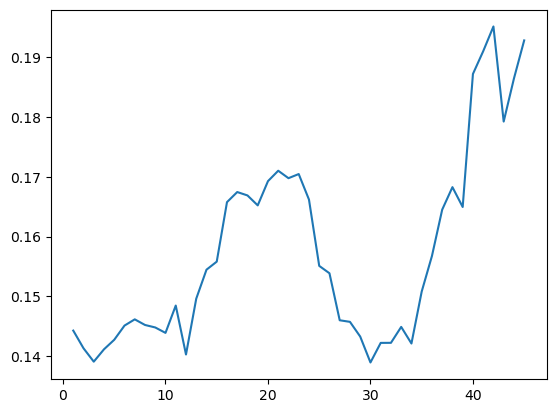

In [48]:
plt.plot(steps, losses)